In [10]:
# Import own modules
# SelfSupervised
import modules.selfsupervised.simclr_model as sm 
import modules.selfsupervised.simclr_train as smtr
# Evaluation
import modules.evaluation.lin_eval_testmoduls as let
# Utils
import modules.utils.transformations as t 
import modules.utils.loss_functions as lf
import modules.utils.lars as lars
# Settings
import modules.utils.get_data as get 
# Reporting 
import modules.utils.reporting as report 
# Saving Model
import modules.utils.save_model as savem
# Get Model
import modules.utils.get_model as gm 
#
import modules.utils.segmentation as seg
#
import modules.utils.utils as ut

# Import extern modules
import argparse
import torch 
from tqdm import tqdm
from statistics import mean 


import seaborn as sns
import matplotlib.pyplot as plt


from torch.nn.parallel import DataParallel
import modules.utils.dataloader as satelliteLoader

In [11]:
def get_IoU(outputs, labels):
    EPS = 1e-15
    outputs = outputs.int()
    labels = labels.int()
    # Taken from: https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (intersection + EPS) / (union + EPS)  # We smooth our devision to avoid 0/0

    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    # return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch
    return iou.mean()

def train_lr(loader, model, criterion, optimizer, epoch, maxepochs, args):
    """
    Input:
        loader: Pytorch dataloader containing the data
        model: The model you want to train
        criterion: Loss function
        optimizer: The optimizer used during training
        epoch: Type int - the epoch the model is currently trained
        maxepochs: The maximal epochs you want to train
        args: Argument list

        Training the evaluation model
    """
    model.train()
    epoch_loss = []
    epoch_acc = []
    epoch_iou = []
    train_bar =  tqdm(loader)

    for x, y in train_bar:
        optimizer.zero_grad()
        masks = y.reshape(y.shape[0], y.shape[2], y.shape[3]).long()
        x = x.to(args.device)
        masks = masks.to(args.device)

        output = model(x)
        loss = criterion(output, masks)
        predicted = output.argmax(1)
        #mean_acc = (masks == predicted) / ((224*224)*masks.shape[0])
        mean_acc = torch.sum(1 - torch.sum(torch.abs(masks - predicted), dim=(1,2)) / (224*224)) / masks.shape[0]
        mean_iou = get_IoU(predicted, masks)
        
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(mean_acc.item())
        epoch_iou.append(mean_iou.item())
        
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}, Acc_Train: {:.4f}'.format(epoch, maxepochs, optimizer.param_groups[0]['lr'], 
                                                                                                        mean(epoch_loss), mean(epoch_acc)))

    return mean(epoch_loss), mean(epoch_acc), mean(epoch_iou)

def test_lr(loader, model, criterion, epoch, maxepochs, args):
    """
    Input:
        loader: Pytorch dataloader containing the data
        model: The model you want to train
        criterion: Loss function
        optimizer: The optimizer used during training
        epoch: Type int - the epoch the model is currently trained
        maxepochs: The maximal epochs you want to train
        args: Argument list

        Testing/Validating the evaluation model
    """
    model.eval()
    epoch_loss = []
    epoch_acc = []
    epoch_iou = []
    test_bar = tqdm(loader)
    with torch.no_grad():
        for x, y in test_bar:
            masks = y.reshape(y.shape[0], y.shape[2], y.shape[3]).long()
            x = x.to(args.device)
            masks = masks.to(args.device)
            
            output = model(x)
            loss = criterion(output, masks)
            predicted = output.argmax(1)
            
            mean_acc = torch.sum(1 - torch.sum(torch.abs(masks - predicted), dim=(1,2)) / (224*224)) / masks.shape[0]
            mean_iou = get_IoU(predicted, masks)
        
            epoch_loss.append(loss.item())
            epoch_acc.append(mean_acc.item())
            epoch_iou.append(mean_iou.item()) 
            
            test_bar.set_description('Val Epoch: [{}/{}], Loss: {:.4f}, Acc_Val: {:.4f}'.format(epoch, maxepochs, mean(epoch_loss), mean(epoch_acc)))

    return mean(epoch_loss), mean(epoch_acc), mean(epoch_iou)

In [19]:
# Create an Argparser
parser = argparse.ArgumentParser(description='Train simCLRv1 on CIFAR-10')
# Model-Architecture
parser.add_argument('-a', '--arch', default='resnet18')
# lr: 0.06 for batch 512 (or 0.03 for batch 256) 0.12 for 1024?
parser.add_argument('--lr', '--learning-rate', default=1e-3, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=20, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--schedule', default=[1020, 1060], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', default="False", type=str, help='use cosine lr schedule')
parser.add_argument('--squared', default="False", type=str, help='use square lr schedule')
parser.add_argument('--batch-size', default=768, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=1e-6, type=float, metavar='W', help='weight decay')
parser.add_argument('--dataset', default="IMAGENET", type=str, metavar='W', help='dataset')
parser.add_argument('--dataset-dir', default="data/imagenet128", type=str, metavar='W', help='dataset directory')
parser.add_argument('--optimizer', default="adam", type=str, metavar='W', help='Adam, SGD, Lars')
# SIMCLR specific configs:
parser.add_argument('--dim', default=128, type=int, help='feature dimension')
parser.add_argument('--t', default=0.1, type=float, help='softmax temperature')
parser.add_argument('--numberviews', default=2, type=int, help='Number of Views created for Avg.Loss')
# Training/Test Settings
parser.add_argument('--model-dir', default="", type=str, metavar='W', help='if test true give model dir!')
parser.add_argument('--model-name', default="", type=str, metavar='W', help='if test true give model dir!')
# Linear Evaluation
parser.add_argument('--epochs-lineval', default=100, type=int, metavar='N', help='number of total epochs to run in linEval')
# Labels
parser.add_argument('--labels', default="full", type=str, metavar='N', help='1%, 10% or full labelled data sets are supported')
# Multiple GPUs
parser.add_argument('--dataparallel', default="True", type=str, metavar='W', help='multiple gpus true or false')
# Reload
parser.add_argument('--reload', default="False", type=str, metavar='W', help='reload true or false')
# Verbose
parser.add_argument('--verbose', default="True", type=str, help='True if you want to evaluate your representations after each epoch (obviously SLOWER!)')

# Set up args
args = parser.parse_args("")

# Convert 
args.dataparallel = True if str.lower(args.dataparallel) == "true" else False
args.reload = True if str.lower(args.reload) == 'true' else False
args.verbose = True if str.lower(args.verbose) == 'true' else False
args.cos = True if str.lower(args.cos) == 'true' else False
args.squared = True if str.lower(args.squared) == 'true' else False
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.num_gpus = torch.cuda.device_count()

In [20]:
args.dataset = "SATELLITE"
args.batch_size = 256
args.lr = 1e-4

In [21]:
dataset_train_nonaug = seg.SatelliteDatasetLabelled(transform=t.TransformsSimCLR_SAT(imgsize=224).test_transform_SAT_SUP, dset="train")

dataset_validation = seg.SatelliteDatasetLabelled(transform=t.TransformsSimCLR_SAT(imgsize=224).test_transform_SAT_SUP, dset="val")

num_workers = 0

trainloader_nonaug = torch.utils.data.DataLoader(dataset_train_nonaug, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valloader = torch.utils.data.DataLoader(dataset_validation, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

In [22]:
encoder = get.encoder(args)
encoder.inputs = 7
model = seg.ResNetSegmentation(base_network=encoder, decoder='s', outputs=2, small_resnet=True).cuda()
model = DataParallel(model)
# Set Optimizer
optimizer = get.optimizer_training(model, args)

criterion = torch.nn.CrossEntropyLoss()
epoch_start = 1

enc [512, 256, 128, 64, 7]
dec (256, 128, 64, 16, 16)


In [23]:
args.epochs = 300

In [24]:
train_losses =[]
val_losses = []
train_accs = []
val_accs = []
train_ious = []
val_ious = []

for epoch in range(epoch_start, args.epochs + 1):
    train_loss, train_acc, train_iou = train_lr(trainloader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_ious.append(train_iou)
    #train_loss, train_acc, lr = st.train(model, train_loader, optimizer, criterion, epoch, args)
    val_loss, val_acc, val_iou = test_lr(valloader, model, criterion, epoch, args.epochs, args)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_ious.append(val_iou)

Train Epoch: [1/300], lr: 0.000100, Loss: 48.0154, Acc_Train: 0.2273: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
Val Epoch: [1/300], Loss: 36.8684, Acc_Val: 0.2094: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
Train Epoch: [2/300], lr: 0.000100, Loss: 44.2465, Acc_Train: 0.2273: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Val Epoch: [2/300], Loss: 32.0713, Acc_Val: 0.2101: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
Train Epoch: [3/300], lr: 0.000100, Loss: 40.4312, Acc_Train: 0.2275: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [3/300], Loss: 28.1308, Acc_Val: 0.2116: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]
Train Epoch: [4/300], lr: 0.000100, Loss: 36.5300, Acc_Train: 0.2277: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [4/300], Loss: 24.5090, Acc_Val: 0.2149: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]
Train Epoch: [5/300], lr: 0.000100, Loss: 32.4966, Acc_Train: 0.2283: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [5/300], Loss: 21

Train Epoch: [39/300], lr: 0.000100, Loss: 0.9670, Acc_Train: 0.8191: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
Val Epoch: [39/300], Loss: 1.0243, Acc_Val: 0.8191: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
Train Epoch: [40/300], lr: 0.000100, Loss: 0.9569, Acc_Train: 0.8206: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Val Epoch: [40/300], Loss: 0.9913, Acc_Val: 0.8196: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
Train Epoch: [41/300], lr: 0.000100, Loss: 0.9367, Acc_Train: 0.8226: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Val Epoch: [41/300], Loss: 0.9606, Acc_Val: 0.8196: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
Train Epoch: [42/300], lr: 0.000100, Loss: 0.9234, Acc_Train: 0.8240: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [42/300], Loss: 0.9252, Acc_Val: 0.8203: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
Train Epoch: [43/300], lr: 0.000100, Loss: 0.9071, Acc_Train: 0.8257: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [43/300], Loss: 0

Train Epoch: [77/300], lr: 0.000100, Loss: 0.6196, Acc_Train: 0.8718: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
Val Epoch: [77/300], Loss: 0.5983, Acc_Val: 0.8716: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
Train Epoch: [78/300], lr: 0.000100, Loss: 0.6133, Acc_Train: 0.8741: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Val Epoch: [78/300], Loss: 0.5953, Acc_Val: 0.8718: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
Train Epoch: [79/300], lr: 0.000100, Loss: 0.6114, Acc_Train: 0.8746: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [79/300], Loss: 0.5927, Acc_Val: 0.8718: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
Train Epoch: [80/300], lr: 0.000100, Loss: 0.6031, Acc_Train: 0.8764: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
Val Epoch: [80/300], Loss: 0.5919, Acc_Val: 0.8713: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]
Train Epoch: [81/300], lr: 0.000100, Loss: 0.6005, Acc_Train: 0.8773: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Val Epoch: [81/300], Loss: 0

Train Epoch: [115/300], lr: 0.000100, Loss: 0.4612, Acc_Train: 0.8971: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [115/300], Loss: 0.5705, Acc_Val: 0.8665: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
Train Epoch: [116/300], lr: 0.000100, Loss: 0.4603, Acc_Train: 0.8969: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
Val Epoch: [116/300], Loss: 0.5806, Acc_Val: 0.8638: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
Train Epoch: [117/300], lr: 0.000100, Loss: 0.4580, Acc_Train: 0.8977: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Val Epoch: [117/300], Loss: 0.5852, Acc_Val: 0.8625: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
Train Epoch: [118/300], lr: 0.000100, Loss: 0.4546, Acc_Train: 0.8988: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [118/300], Loss: 0.5834, Acc_Val: 0.8626: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
Train Epoch: [119/300], lr: 0.000100, Loss: 0.4596, Acc_Train: 0.8982: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
Val Epoch: [119/300

Val Epoch: [152/300], Loss: 0.4094, Acc_Val: 0.9011: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
Train Epoch: [153/300], lr: 0.000100, Loss: 0.3503, Acc_Train: 0.9163: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
Val Epoch: [153/300], Loss: 0.4129, Acc_Val: 0.9002: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
Train Epoch: [154/300], lr: 0.000100, Loss: 0.3475, Acc_Train: 0.9171: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
Val Epoch: [154/300], Loss: 0.3970, Acc_Val: 0.9042: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
Train Epoch: [155/300], lr: 0.000100, Loss: 0.3449, Acc_Train: 0.9175: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [155/300], Loss: 0.3813, Acc_Val: 0.9083: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
Train Epoch: [156/300], lr: 0.000100, Loss: 0.3409, Acc_Train: 0.9181: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Val Epoch: [156/300], Loss: 0.3750, Acc_Val: 0.9099: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]
Train Epoch: [157/300], lr: 0.000100,

Train Epoch: [190/300], lr: 0.000100, Loss: 0.2559, Acc_Train: 0.9327: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Val Epoch: [190/300], Loss: 0.3169, Acc_Val: 0.9193: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
Train Epoch: [191/300], lr: 0.000100, Loss: 0.2509, Acc_Train: 0.9333: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Val Epoch: [191/300], Loss: 0.3264, Acc_Val: 0.9172: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
Train Epoch: [192/300], lr: 0.000100, Loss: 0.2500, Acc_Train: 0.9331: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
Val Epoch: [192/300], Loss: 0.3186, Acc_Val: 0.9193: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
Train Epoch: [193/300], lr: 0.000100, Loss: 0.2492, Acc_Train: 0.9339: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Val Epoch: [193/300], Loss: 0.3261, Acc_Val: 0.9186: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
Train Epoch: [194/300], lr: 0.000100, Loss: 0.2480, Acc_Train: 0.9343: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
Val Epoch: [194/300

Val Epoch: [227/300], Loss: 0.3063, Acc_Val: 0.9175: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
Train Epoch: [228/300], lr: 0.000100, Loss: 0.2041, Acc_Train: 0.9422: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [228/300], Loss: 0.3052, Acc_Val: 0.9176: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
Train Epoch: [229/300], lr: 0.000100, Loss: 0.2053, Acc_Train: 0.9414: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [229/300], Loss: 0.2766, Acc_Val: 0.9248: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
Train Epoch: [230/300], lr: 0.000100, Loss: 0.2102, Acc_Train: 0.9415: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Val Epoch: [230/300], Loss: 0.2807, Acc_Val: 0.9234: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
Train Epoch: [231/300], lr: 0.000100, Loss: 0.2023, Acc_Train: 0.9430: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Val Epoch: [231/300], Loss: 0.2910, Acc_Val: 0.9206: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]
Train Epoch: [232/300], lr: 0.000100,

Train Epoch: [265/300], lr: 0.000100, Loss: 0.1771, Acc_Train: 0.9474: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Val Epoch: [265/300], Loss: 0.2713, Acc_Val: 0.9247: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
Train Epoch: [266/300], lr: 0.000100, Loss: 0.1776, Acc_Train: 0.9478: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Val Epoch: [266/300], Loss: 0.2720, Acc_Val: 0.9243: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
Train Epoch: [267/300], lr: 0.000100, Loss: 0.1771, Acc_Train: 0.9475: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
Val Epoch: [267/300], Loss: 0.2689, Acc_Val: 0.9248: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]
Train Epoch: [268/300], lr: 0.000100, Loss: 0.1765, Acc_Train: 0.9476: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Val Epoch: [268/300], Loss: 0.2659, Acc_Val: 0.9250: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
Train Epoch: [269/300], lr: 0.000100, Loss: 0.1772, Acc_Train: 0.9469: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
Val Epoch: [269/300

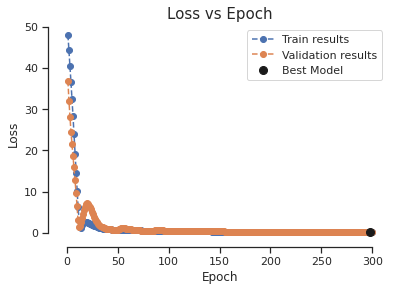

Best Loss-Value for Validation: 0.2485726922750473 at Epoch 298


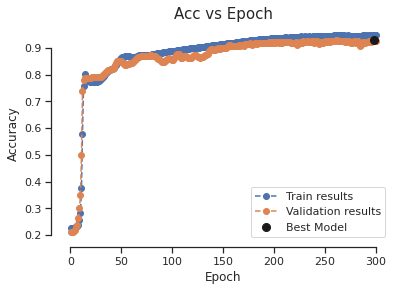

Best Accuracy for Validation: 0.9282955527305603 at Epoch 298


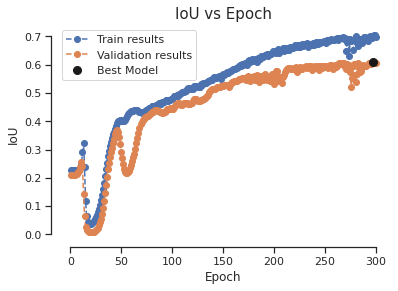

Best IoU for Validation: 0.6092438101768494 at Epoch 297


In [25]:
min_value = min(val_losses)
min_index = val_losses.index(min_value)+1

seg.plot("Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=(min_index, min_value), extra_pt_label="Best Model")
print(f"Best Loss-Value for Validation: {min_value} at Epoch {min_index}")

max_value = max(val_accs)
max_index = val_accs.index(max_value)+1
seg.plot("Acc vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best Accuracy for Validation: {max_value} at Epoch {max_index}")

max_value = max(val_ious)
max_index = val_ious.index(max_value)+1
seg.plot("IoU vs Epoch", "IoU", train_ious, val_ious, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best IoU for Validation: {max_value} at Epoch {max_index}")

In [26]:
for images, masks in valloader: #trainloader_nonaug
    model.eval()
    masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3]).long().cuda()
    output = model(images.cuda())
    loss = criterion(output, masks)
    predicted = output.argmax(1)
    break

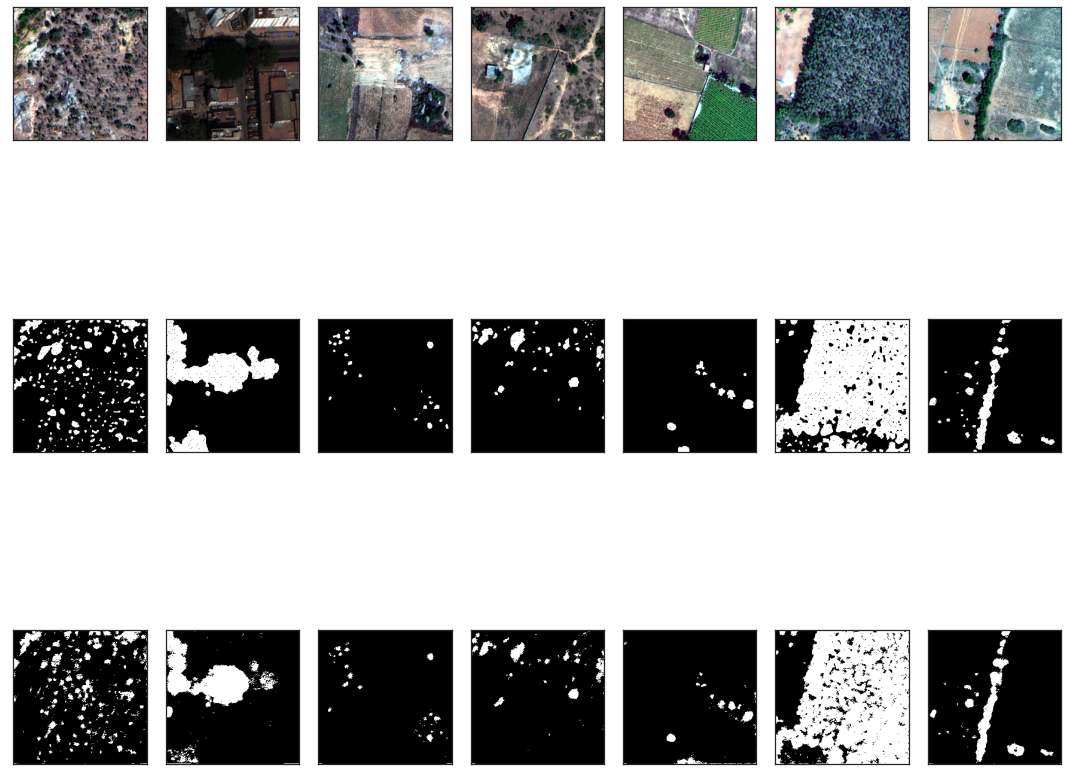

In [27]:
n_images = 7
cols = n_images
rows = 3
plt.figure(figsize=(15, 15))
for i in range(n_images*rows):
    if i<n_images:
        img = images[i][(3,1,0),:,:].permute(1,2,0)
        img = ut.percentile(img, mode="layerwise", copy=True)
    elif i<n_images*2:
        img = masks.cpu()[i-n_images][:,:]
    else:
        img = predicted.cpu()[i-n_images*2][:,:]
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [38]:
args.batch_size = 64
args.arch = "resnet50"

In [39]:
dataset_train_nonaug = seg.SatelliteDatasetLabelled(transform=t.TransformsSimCLR_SAT(imgsize=224).test_transform_SAT_SUP, dset="train")

dataset_validation = seg.SatelliteDatasetLabelled(transform=t.TransformsSimCLR_SAT(imgsize=224).test_transform_SAT_SUP, dset="val")

num_workers = 0

trainloader_nonaug = torch.utils.data.DataLoader(dataset_train_nonaug, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valloader = torch.utils.data.DataLoader(dataset_validation, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

In [40]:
encoder = get.encoder(args)
encoder.inputs = 7
model = seg.ResNetSegmentation(base_network=encoder, decoder='s', outputs=2, small_resnet=False).cuda()
model = DataParallel(model)
# Set Optimizer
optimizer = get.optimizer_training(model, args)

criterion = torch.nn.CrossEntropyLoss()
epoch_start = 1

enc [2048, 1024, 512, 256, 7]
dec (256, 128, 64, 16, 16)


In [41]:
args.epochs = 300

In [42]:
train_losses =[]
val_losses = []
train_accs = []
val_accs = []
train_ious = []
val_ious = []

for epoch in range(epoch_start, args.epochs + 1):
    train_loss, train_acc, train_iou = train_lr(trainloader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_ious.append(train_iou)
    #train_loss, train_acc, lr = st.train(model, train_loader, optimizer, criterion, epoch, args)
    val_loss, val_acc, val_iou = test_lr(valloader, model, criterion, epoch, args.epochs, args)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_ious.append(val_iou)

Train Epoch: [1/300], lr: 0.000100, Loss: 3.4942, Acc_Train: 0.5959: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Val Epoch: [1/300], Loss: 4.0660, Acc_Val: 0.7852: 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]
Train Epoch: [2/300], lr: 0.000100, Loss: 3.0334, Acc_Train: 0.7087: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
Val Epoch: [2/300], Loss: 2.3015, Acc_Val: 0.7068: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]
Train Epoch: [3/300], lr: 0.000100, Loss: 2.1107, Acc_Train: 0.5971: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
Val Epoch: [3/300], Loss: 1.6990, Acc_Val: 0.5948: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]
Train Epoch: [4/300], lr: 0.000100, Loss: 1.5870, Acc_Train: 0.6334: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
Val Epoch: [4/300], Loss: 1.1692, Acc_Val: 0.7272: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]
Train Epoch: [5/300], lr: 0.000100, Loss: 1.2656, Acc_Train: 0.7275: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
Val Epoch: [5/300], Loss: 1.0759, Acc

Train Epoch: [39/300], lr: 0.000100, Loss: 0.2877, Acc_Train: 0.9122: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
Val Epoch: [39/300], Loss: 0.2910, Acc_Val: 0.9103: 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]
Train Epoch: [40/300], lr: 0.000100, Loss: 0.2777, Acc_Train: 0.9150: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]
Val Epoch: [40/300], Loss: 0.3003, Acc_Val: 0.9079: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]
Train Epoch: [41/300], lr: 0.000100, Loss: 0.3071, Acc_Train: 0.9058: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]
Val Epoch: [41/300], Loss: 0.3459, Acc_Val: 0.8997: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]
Train Epoch: [42/300], lr: 0.000100, Loss: 0.3239, Acc_Train: 0.9074: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
Val Epoch: [42/300], Loss: 0.3012, Acc_Val: 0.9111: 100%|██████████| 2/2 [00:00<00:00,  5.53it/s]
Train Epoch: [43/300], lr: 0.000100, Loss: 0.2651, Acc_Train: 0.9191: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Val Epoch: [43/300], Loss: 0

Train Epoch: [77/300], lr: 0.000100, Loss: 0.2425, Acc_Train: 0.9209: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Val Epoch: [77/300], Loss: 0.2802, Acc_Val: 0.9111: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]
Train Epoch: [78/300], lr: 0.000100, Loss: 0.2211, Acc_Train: 0.9285: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Val Epoch: [78/300], Loss: 0.2455, Acc_Val: 0.9231: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]
Train Epoch: [79/300], lr: 0.000100, Loss: 0.2110, Acc_Train: 0.9316: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Val Epoch: [79/300], Loss: 0.2451, Acc_Val: 0.9223: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]
Train Epoch: [80/300], lr: 0.000100, Loss: 0.2206, Acc_Train: 0.9279: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Val Epoch: [80/300], Loss: 0.2824, Acc_Val: 0.9143: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]
Train Epoch: [81/300], lr: 0.000100, Loss: 0.1983, Acc_Train: 0.9337: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]
Val Epoch: [81/300], Loss: 0

Train Epoch: [115/300], lr: 0.000100, Loss: 0.1680, Acc_Train: 0.9429: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]
Val Epoch: [115/300], Loss: 0.1986, Acc_Val: 0.9304: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]
Train Epoch: [116/300], lr: 0.000100, Loss: 0.1888, Acc_Train: 0.9344: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]
Val Epoch: [116/300], Loss: 0.2286, Acc_Val: 0.9239: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]
Train Epoch: [117/300], lr: 0.000100, Loss: 0.1615, Acc_Train: 0.9448: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]
Val Epoch: [117/300], Loss: 0.4286, Acc_Val: 0.8859: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]
Train Epoch: [118/300], lr: 0.000100, Loss: 0.1573, Acc_Train: 0.9460: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]
Val Epoch: [118/300], Loss: 0.5175, Acc_Val: 0.8778: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]
Train Epoch: [119/300], lr: 0.000100, Loss: 0.1643, Acc_Train: 0.9431: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
Val Epoch: [119/300

Val Epoch: [152/300], Loss: 0.1952, Acc_Val: 0.9316: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]
Train Epoch: [153/300], lr: 0.000100, Loss: 0.1356, Acc_Train: 0.9510: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]
Val Epoch: [153/300], Loss: 0.1963, Acc_Val: 0.9327: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]
Train Epoch: [154/300], lr: 0.000100, Loss: 0.1432, Acc_Train: 0.9481: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
Val Epoch: [154/300], Loss: 0.1978, Acc_Val: 0.9319: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]
Train Epoch: [155/300], lr: 0.000100, Loss: 0.1291, Acc_Train: 0.9531: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Val Epoch: [155/300], Loss: 0.1991, Acc_Val: 0.9322: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]
Train Epoch: [156/300], lr: 0.000100, Loss: 0.1409, Acc_Train: 0.9484: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Val Epoch: [156/300], Loss: 0.1737, Acc_Val: 0.9373: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]
Train Epoch: [157/300], lr: 0.000100,

Train Epoch: [190/300], lr: 0.000100, Loss: 0.1397, Acc_Train: 0.9480: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Val Epoch: [190/300], Loss: 0.2553, Acc_Val: 0.9129: 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]
Train Epoch: [191/300], lr: 0.000100, Loss: 0.1323, Acc_Train: 0.9507: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]
Val Epoch: [191/300], Loss: 0.1976, Acc_Val: 0.9286: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]
Train Epoch: [192/300], lr: 0.000100, Loss: 0.1332, Acc_Train: 0.9498: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]
Val Epoch: [192/300], Loss: 0.1946, Acc_Val: 0.9278: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]
Train Epoch: [193/300], lr: 0.000100, Loss: 0.1342, Acc_Train: 0.9503: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
Val Epoch: [193/300], Loss: 0.2159, Acc_Val: 0.9215: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]
Train Epoch: [194/300], lr: 0.000100, Loss: 0.1290, Acc_Train: 0.9513: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
Val Epoch: [194/300

Val Epoch: [227/300], Loss: 0.1734, Acc_Val: 0.9326: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]
Train Epoch: [228/300], lr: 0.000100, Loss: 0.1333, Acc_Train: 0.9490: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Val Epoch: [228/300], Loss: 0.2757, Acc_Val: 0.9095: 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]
Train Epoch: [229/300], lr: 0.000100, Loss: 0.1421, Acc_Train: 0.9482: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]
Val Epoch: [229/300], Loss: 0.1946, Acc_Val: 0.9258: 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]
Train Epoch: [230/300], lr: 0.000100, Loss: 0.1434, Acc_Train: 0.9463: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Val Epoch: [230/300], Loss: 0.3272, Acc_Val: 0.8965: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]
Train Epoch: [231/300], lr: 0.000100, Loss: 0.1554, Acc_Train: 0.9437: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]
Val Epoch: [231/300], Loss: 0.2173, Acc_Val: 0.9198: 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]
Train Epoch: [232/300], lr: 0.000100,

Train Epoch: [265/300], lr: 0.000100, Loss: 0.1181, Acc_Train: 0.9553: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Val Epoch: [265/300], Loss: 0.1880, Acc_Val: 0.9344: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]
Train Epoch: [266/300], lr: 0.000100, Loss: 0.1118, Acc_Train: 0.9579: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Val Epoch: [266/300], Loss: 0.1856, Acc_Val: 0.9318: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]
Train Epoch: [267/300], lr: 0.000100, Loss: 0.1169, Acc_Train: 0.9541: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Val Epoch: [267/300], Loss: 0.2169, Acc_Val: 0.9244: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]
Train Epoch: [268/300], lr: 0.000100, Loss: 0.1234, Acc_Train: 0.9529: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Val Epoch: [268/300], Loss: 0.2005, Acc_Val: 0.9274: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]
Train Epoch: [269/300], lr: 0.000100, Loss: 0.1141, Acc_Train: 0.9575: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Val Epoch: [269/300

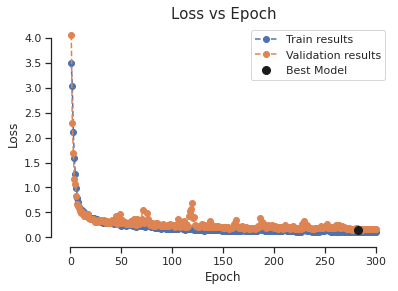

Best Loss-Value for Validation: 0.1453246809542179 at Epoch 283


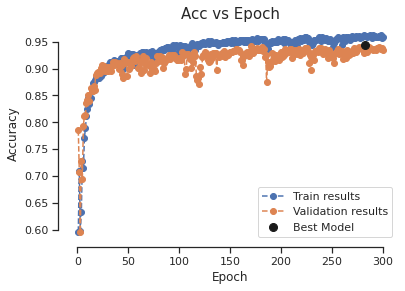

Best Accuracy for Validation: 0.9442803859710693 at Epoch 283


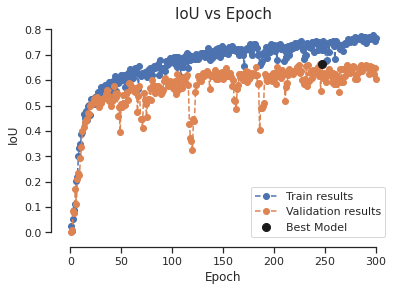

Best IoU for Validation: 0.6645422279834747 at Epoch 247


In [43]:
min_value = min(val_losses)
min_index = val_losses.index(min_value)+1

seg.plot("Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=(min_index, min_value), extra_pt_label="Best Model")
print(f"Best Loss-Value for Validation: {min_value} at Epoch {min_index}")

max_value = max(val_accs)
max_index = val_accs.index(max_value)+1
seg.plot("Acc vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best Accuracy for Validation: {max_value} at Epoch {max_index}")

max_value = max(val_ious)
max_index = val_ious.index(max_value)+1
seg.plot("IoU vs Epoch", "IoU", train_ious, val_ious, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best IoU for Validation: {max_value} at Epoch {max_index}")

In [44]:
for images, masks in valloader: #trainloader_nonaug
    model.eval()
    masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3]).long().cuda()
    output = model(images.cuda())
    loss = criterion(output, masks)
    predicted = output.argmax(1)
    break

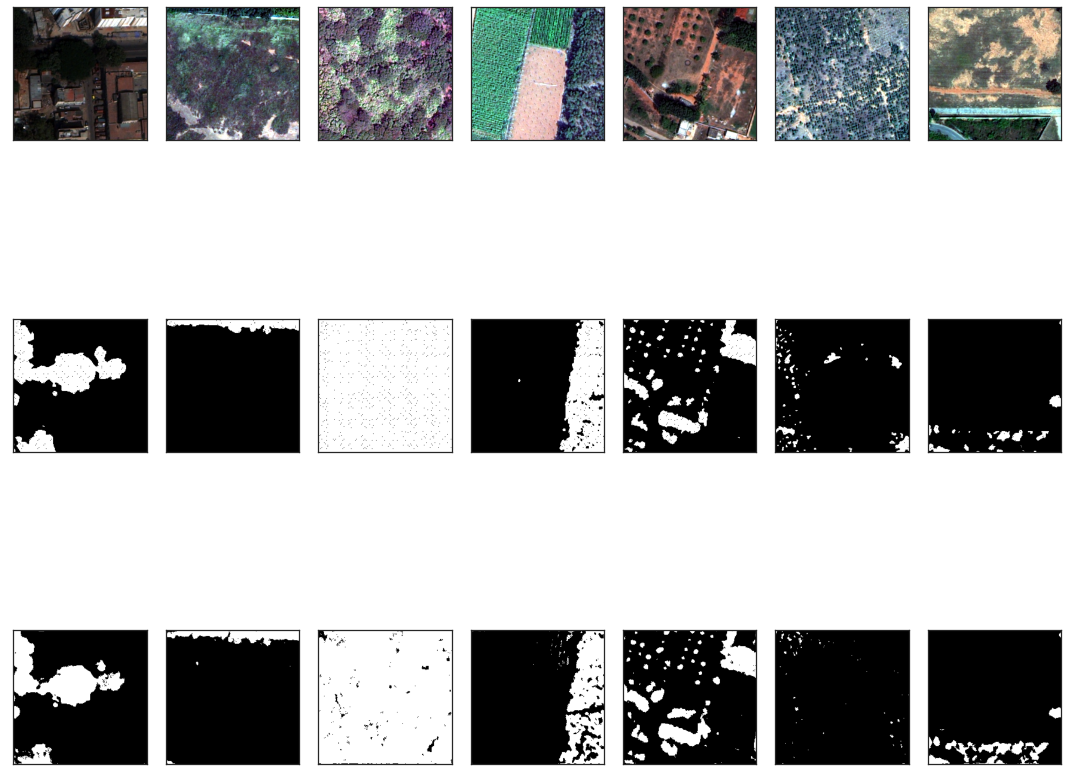

In [45]:
n_images = 7
cols = n_images
rows = 3
plt.figure(figsize=(15, 15))
for i in range(n_images*rows):
    if i<n_images:
        img = images[i][(3,1,0),:,:].permute(1,2,0)
        img = ut.percentile(img, mode="layerwise", copy=True)
    elif i<n_images*2:
        img = masks.cpu()[i-n_images][:,:]
    else:
        img = predicted.cpu()[i-n_images*2][:,:]
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()